# Image generation

We have embeddings of the keywords of hundreds of popular movies and a pre-trained image classification network. We'll be using the network for feature extraction, then backpropagating through it to make the image features match movie vectors.

## Loading & utils

In [0]:
import pandas as pd
import numpy as np
import skimage.io
import torch
import torchvision
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import os
import shutil

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
def images_to_tensor(images):
    return torch.tensor(images, requires_grad=True, dtype=torch.float, device=device)

def tensor_to_images(tensor):
    return tensor.detach().cpu().numpy()

In [0]:
def preview(image, title='example image', large=True):
    if large:
        plt.figure(figsize=(8, 8))
    plt.title(title)
    plt.imshow(image)
    plt.show()

In [5]:
movies = pd.read_csv('movies/processed.csv')
movie_vectors = np.array([np.fromstring(vector, sep=' ') for vector in movies['vector']])
print(f'movie_vectors: shape {movie_vectors.shape}, std {movie_vectors.std()}')

movie_vectors: shape (256, 256), std 0.13175606533853548


## Feature extraction

In [0]:
class FeatureNet(torch.nn.Module):
    def __init__(self, base=torchvision.models.googlenet, depth=9):
        super(FeatureNet, self).__init__()
        slave = base(pretrained=True)
        used_slave_layers = [layer for _, layer in list(slave._modules.items())[:depth]]
        self.feature_extractor = torch.nn.Sequential(*used_slave_layers)
        self.norm_mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float, device=device)
        self.norm_std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float, device=device)
    
    def forward(self, images):
        normalized = (images - self.norm_mean) / self.norm_std
        permuted = normalized.permute(0, 3, 1, 2)
        features = self.feature_extractor(permuted)
        return features.mean(axis=(2, 3))

In [0]:
feature_net = FeatureNet().eval().to(device)

## Generation

In [0]:
def jitter(image_tensors, jitter=64):
    dy, dx = np.random.randint(-jitter, jitter + 1, 2)
    return image_tensors.roll((dy, dx), (2, 3))


def zoom_out(image_tensors, factor=2):
    return torch.nn.AvgPool2d(factor, stride=factor)(image_tensors)


def inverse_sigmoid(images):
    return -np.log(1 / np.array(images) - 1)

In [0]:
def feature_loss(image_tensors, vector_tensors, scales=[1, 2, 3]):
    result = torch.zeros([image_tensors.shape[0]], dtype=torch.float, device=device)
    for scale in scales:
        transformed = zoom_out(jitter(image_tensors), scale)
        features = feature_net(transformed)
        num_feature_batches = features.shape[1] // vector_tensors.shape[1]
        used_features = features[:, :num_feature_batches * vector_tensors.shape[1]]
        pooled_features = used_features.view(features.shape[0], num_feature_batches, vector_tensors.shape[1]).mean(axis=1)
        result -= torch.mean(pooled_features * vector_tensors)
    return result.sum()

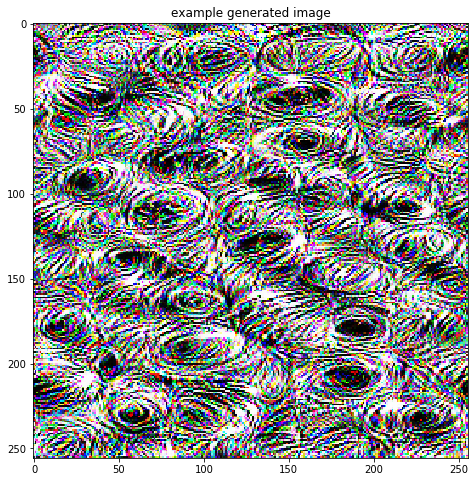

In [12]:
def guide(images, vectors, num_steps=64, lr=0.2):
    '''optimize images so that their features match corresponding vectors'''
    images = images_to_tensor(inverse_sigmoid(images))
    vectors = torch.tensor(vectors, dtype=torch.float, device=device)
    optimizer = torch.optim.Adam([images], lr=lr)
    for step in tqdm(range(num_steps)):
        optimizer.zero_grad()
        feature_loss(torch.sigmoid(images), vectors).backward()
        optimizer.step()
    return tensor_to_images(torch.sigmoid(images))


def generate(vectors, shape=(256, 256), *args, **kwargs):
    seeds = np.random.rand(len(vectors), *shape, 3)
    return guide(seeds, vectors, *args, **kwargs)


preview(generate(movie_vectors[0:1])[0], 'example generated image')

In [14]:
generated = []
for vectors in tqdm(np.array_split(movie_vectors, 16)):
    generated += list(generate(vectors))
generated = np.array(generated)

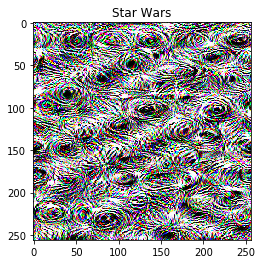

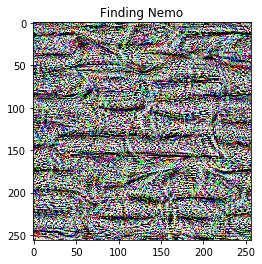

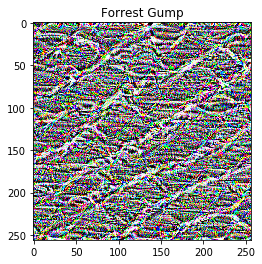

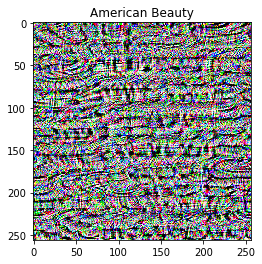

In [15]:
for image, (index, row) in zip(generated[:4], movies.iterrows()):
    plt.title(row['title'])
    plt.imshow(image)
    plt.show()

## Saving

In [0]:
output_dir = 'generated'
shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok=True)

for image, (index, row) in zip(generated, movies.iterrows()):
    image_uint8 = (image * 255.5).astype(np.uint8)
    skimage.io.imsave(f'{output_dir}/{index}.png', image_uint8)